<a href="https://colab.research.google.com/github/canxiu-zhang/ML_YUniv/blob/main/ml_1010/group_projects/milestone_2/Milestone_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem definition: There are multiple genres for each movie in our dataset. In order to build a Multi-Label Classification model to predict genres by giving movie overview, pre-processing this target variable is required.


Task #1: The column Genre represents a list of genres associated with the movie in a string format. The task is to write code to parse each top 5 genres into a binary vector with 1s representing the presence of a genre and 0s the absence, and add it to the dataframe as additional columns.


Task #2: Use NLP to pre-processing 'overview' and split training and testing data to be ready for modeling

## 1. EDA

In [89]:
# !pip install contractions
# !pip install unicodedata

In [90]:
import os
import csv
import pandas as pd
import numpy as np
import spacy
import contractions
import unicodedata
import pprint
%pprint

Pretty printing has been turned ON


In [91]:
df = pd.read_csv('tmdb_movies_data.csv')

### Parse top 5 genres in a column into a binary vector

In [92]:
# Identify the column that contains the multiple genre labels
genre_column = 'genres'

# Create a list of all possible genre labels in your dataset
all_genres = ['Action', 'Comedy', 'Drama', 'Thriller', 'Romance']

# Use get_dummies() to convert the genre column into binary columns
genre_dummies = df[genre_column].str.get_dummies(sep='|').reindex(columns=all_genres, fill_value=1)

# Merge the new DataFrame with the original DataFrame
merged_df = pd.concat([df, genre_dummies], axis=1)

# Drop columns from the DataFrame
merged_df.drop(['imdb_id', 'popularity', 'budget', 'revenue', 'original_title', 'cast', 'homepage', 'director', 'tagline', 'keywords', 'runtime', 'production_companies', 'release_date', 'vote_count', 'vote_average', 'release_year', 'budget_adj', 'revenue_adj'], axis=1, inplace=True)

# Print the new DataFrame
print(merged_df.head())

       id                                           overview  \
0  135397  Twenty-two years after the events of Jurassic ...   
1   76341  An apocalyptic story set in the furthest reach...   
2  262500  Beatrice Prior must confront her inner demons ...   
3  140607  Thirty years after defeating the Galactic Empi...   
4  168259  Deckard Shaw seeks revenge against Dominic Tor...   

                                      genres  Action  Comedy  Drama  Thriller  \
0  Action|Adventure|Science Fiction|Thriller       1       0      0         1   
1  Action|Adventure|Science Fiction|Thriller       1       0      0         1   
2         Adventure|Science Fiction|Thriller       0       0      0         1   
3   Action|Adventure|Science Fiction|Fantasy       1       0      0         0   
4                      Action|Crime|Thriller       1       0      0         1   

   Romance  
0        0  
1        0  
2        0  
3        0  
4        0  


In [93]:
missing_values_check = merged_df.isnull().sum()
print(missing_values_check)

id           0
overview     4
genres      23
Action       0
Comedy       0
Drama        0
Thriller     0
Romance      0
dtype: int64


In [94]:
categories = list(merged_df.columns.values)
categories = categories[3:]
print(categories)

['Action', 'Comedy', 'Drama', 'Thriller', 'Romance']


In [95]:
# Calculating number of comments in each category

counts = []
for category in categories:
    counts.append((category, merged_df[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of overviews'])
df_stats

,category,number of overviews
0,Action,2385
1,Comedy,3793
2,Drama,4761
3,Thriller,2908
4,Romance,1712


## 2. Data Pre-Processing

In [96]:
data = merged_df
data.shape

(10866, 8)

In [97]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Cleaning Data

In [98]:
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext


def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned


def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeSpecial(sentence):
    # Remove special characters using regular expression
    clean_text = re.sub(r'[^\w\s]', '', sentence)
    return clean_text

def removeAccent(sentence):
    # Remove accent characters using the unicodedata module
    no_accent_text = ''.join(char for char in unicodedata.normalize('NFD', sentence) if unicodedata.category(char) != 'Mn')
    return no_accent_text

def removeContraction(sentence):
    # Expand contractions using contractions library
    expanded_text = contractions.fix(sentence)
    return expanded_text

In [99]:
data['overview'] = data['overview'].str.lower()
data['overview'] = data['overview'].apply(cleanHtml)
data['overview'] = data['overview'].apply(cleanPunc)
data['overview'] = data['overview'].apply(keepAlpha)
data['overview'] = data['overview'].apply(removeSpecial)
data['overview'] = data['overview'].apply(removeAccent)
data['overview'] = data['overview'].apply(removeContraction)
data.head()

,id,overview,genres,Action,Comedy,Drama,Thriller,Romance
0,135397,twenty two years after the events of jurassic ...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
1,76341,an apocalyptic story set in the furthest reach...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
2,262500,beatrice prior must confront her inner demons ...,Adventure|Science Fiction|Thriller,0,0,0,1,0
3,140607,thirty years after defeating the galactic empi...,Action|Adventure|Science Fiction|Fantasy,1,0,0,0,0
4,168259,deckard shaw seeks revenge against dominic tor...,Action|Crime|Thriller,1,0,0,1,0


### Removing Stop Words

In [100]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [101]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

data['overview'] = data['overview'].apply(removeStopWords)
data.head()

,id,overview,genres,Action,Comedy,Drama,Thriller,Romance
0,135397,twenty years events jurassic park isla nub...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
1,76341,apocalyptic story set furthest reaches pl...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
2,262500,beatrice prior must confront inner demons co...,Adventure|Science Fiction|Thriller,0,0,0,1,0
3,140607,thirty years defeating galactic empire han s...,Action|Adventure|Science Fiction|Fantasy,1,0,0,0,0
4,168259,deckard shaw seeks revenge dominic toretto ...,Action|Crime|Thriller,1,0,0,1,0


### Stemming

In [102]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

# data['overview'] = data['overview'].apply(stemming)
data.head()

,id,overview,genres,Action,Comedy,Drama,Thriller,Romance
0,135397,twenty years events jurassic park isla nub...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
1,76341,apocalyptic story set furthest reaches pl...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
2,262500,beatrice prior must confront inner demons co...,Adventure|Science Fiction|Thriller,0,0,0,1,0
3,140607,thirty years defeating galactic empire han s...,Action|Adventure|Science Fiction|Fantasy,1,0,0,0,0
4,168259,deckard shaw seeks revenge dominic toretto ...,Action|Crime|Thriller,1,0,0,1,0


### Lemmatization

In [112]:
nlp = spacy.load('en_core_web_sm')
def lemmatization(sentence):
  doc = nlp(sentence)
  lemmas = [token.lemma_ for token in doc]
  lemmas = [l.strip() for l in lemmas]
  return " ".join(lemmas)

data['overview'] = data['overview'].apply(lemmatization)
data.head()

,id,overview,genres,Action,Comedy,Drama,Thriller,Romance
0,135397,twenty year event jurassic park isla nublar...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
1,76341,apocalyptic story set furth reach planet s...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
2,262500,beatrice prior must confront inner demon con...,Adventure|Science Fiction|Thriller,0,0,0,1,0
3,140607,thirty year defeat galactic empire han solo ...,Action|Adventure|Science Fiction|Fantasy,1,0,0,0,0
4,168259,deckard shaw seek revenge dominic toretto fa...,Action|Crime|Thriller,1,0,0,1,0


### Train-Test Split

In [113]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

print(train.shape)
print(test.shape)

(7606, 8)
(3260, 8)


In [115]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [116]:
train_text = train['overview']
test_text = test['overview']

### TF-IDF

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
# vectorizer.fit(train_text)
# vectorizer.fit(test_text)

TfidfVectorizer(ngram_range=(1, 3), strip_accents='unicode')

In [ ]:
# x_train = vectorizer.transform(train_text)
# y_train = train.drop(labels = ['id','overview', 'genres'], axis=1)

# x_test = vectorizer.transform(test_text)
# y_test = test.drop(labels = ['id','overview', 'genres'], axis=1)

## Feature Engineering

### Bigrams

In [134]:
from gensim.models.phrases import Phrases, Phraser
from nltk import bigrams

words = [row.split() for row in train['overview']]
phrases = Phrases(words, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[words]

### word2vec

In [135]:
import multiprocessing
from gensim.models import Word2Vec

In [136]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [137]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                    #  size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [138]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [144]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(2071867, 6735480)

In [145]:
w2v_model.init_sims(replace=True)

<ipython-input-145-c7757d71a30b>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [146]:
w2v_model.wv.most_similar(positive=["life"])

[('affect', 0.9346920847892761),
 ('unexpected', 0.9171165227890015),
 ('emotional', 0.9149538278579712),
 ('strong', 0.9091325998306274),
 ('change', 0.9071929454803467),
 ('develop', 0.9032014608383179),
 ('connect', 0.8928252458572388),
 ('question', 0.8892859816551208),
 ('friendship', 0.884784460067749),
 ('other', 0.8819547295570374)]

In [148]:
w2v_model.wv.most_similar(positive=["find"])

[('casey', 0.9333626627922058),
 ('soon', 0.9332592487335205),
 ('he', 0.9304161071777344),
 ('place', 0.9256977438926697),
 ('another', 0.9237446784973145),
 ('unaware', 0.9209941625595093),
 ('mysteriously', 0.9181034564971924),
 ('stranger', 0.9160672426223755),
 ('rely', 0.9154044389724731),
 ('discover', 0.9143154621124268)]

In [149]:
w2v_model.wv.most_similar(positive=["she"])

[('another', 0.9598732590675354),
 ('intention', 0.946467399597168),
 ('table', 0.9419368505477905),
 ('he', 0.9370694160461426),
 ('finally', 0.9362800121307373),
 ('emotionally', 0.9328795075416565),
 ('close', 0.9320226907730103),
 ('unable', 0.9314445853233337),
 ('keep', 0.9313143491744995),
 ('stranger', 0.9311810731887817)]

### t-SNE visualizations

In [150]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [158]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-19, Y[:, 0].max()+19)
    plt.ylim(Y[:, 1].min()-19, Y[:, 1].max()+19)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

#### 10 Most similar words vs. 8 Random words

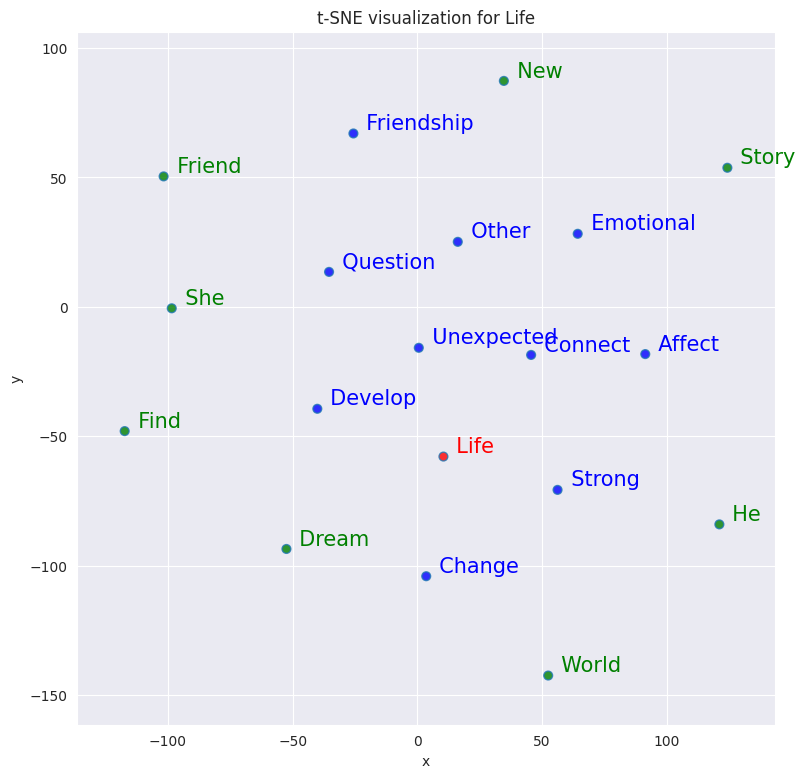

In [162]:
tsnescatterplot(w2v_model, 'life', ['friend', 'story', 'dream', 'she', 'he', 'world', 'find', 'new'])

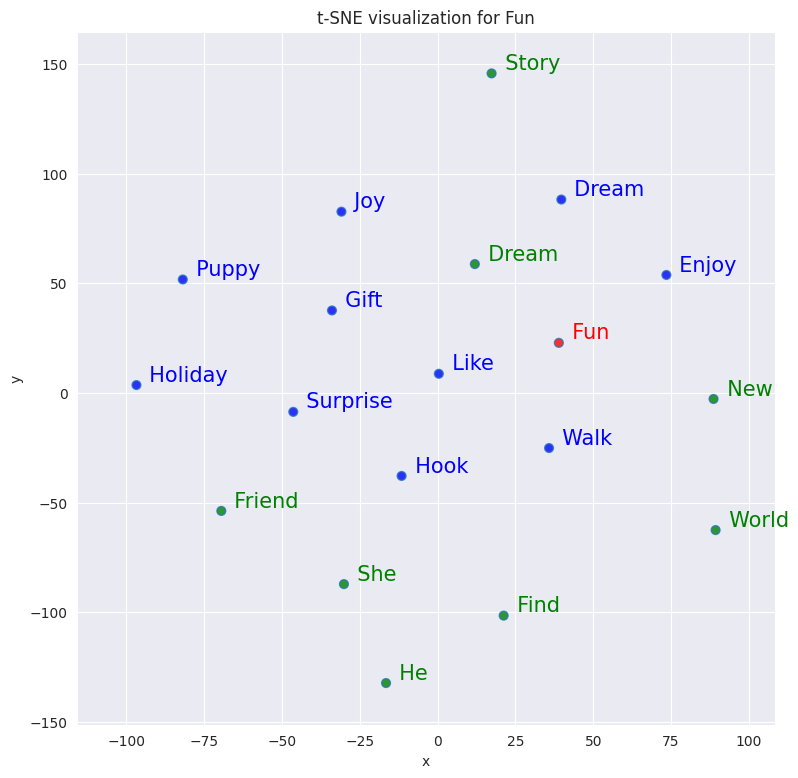

In [164]:
tsnescatterplot(w2v_model, 'fun', ['friend', 'story', 'dream', 'she', 'he', 'world', 'find', 'new'])

#### Plot w2v model

In [190]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.key_to_index:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(n_components=2, n_iter=2500, random_state=23)
    tokens_array = np.array(tokens)  # convert list to numpy array
    new_values = tsne_model.fit_transform(tokens_array)

    x = new_values[:,0]
    y = new_values[:,1]
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

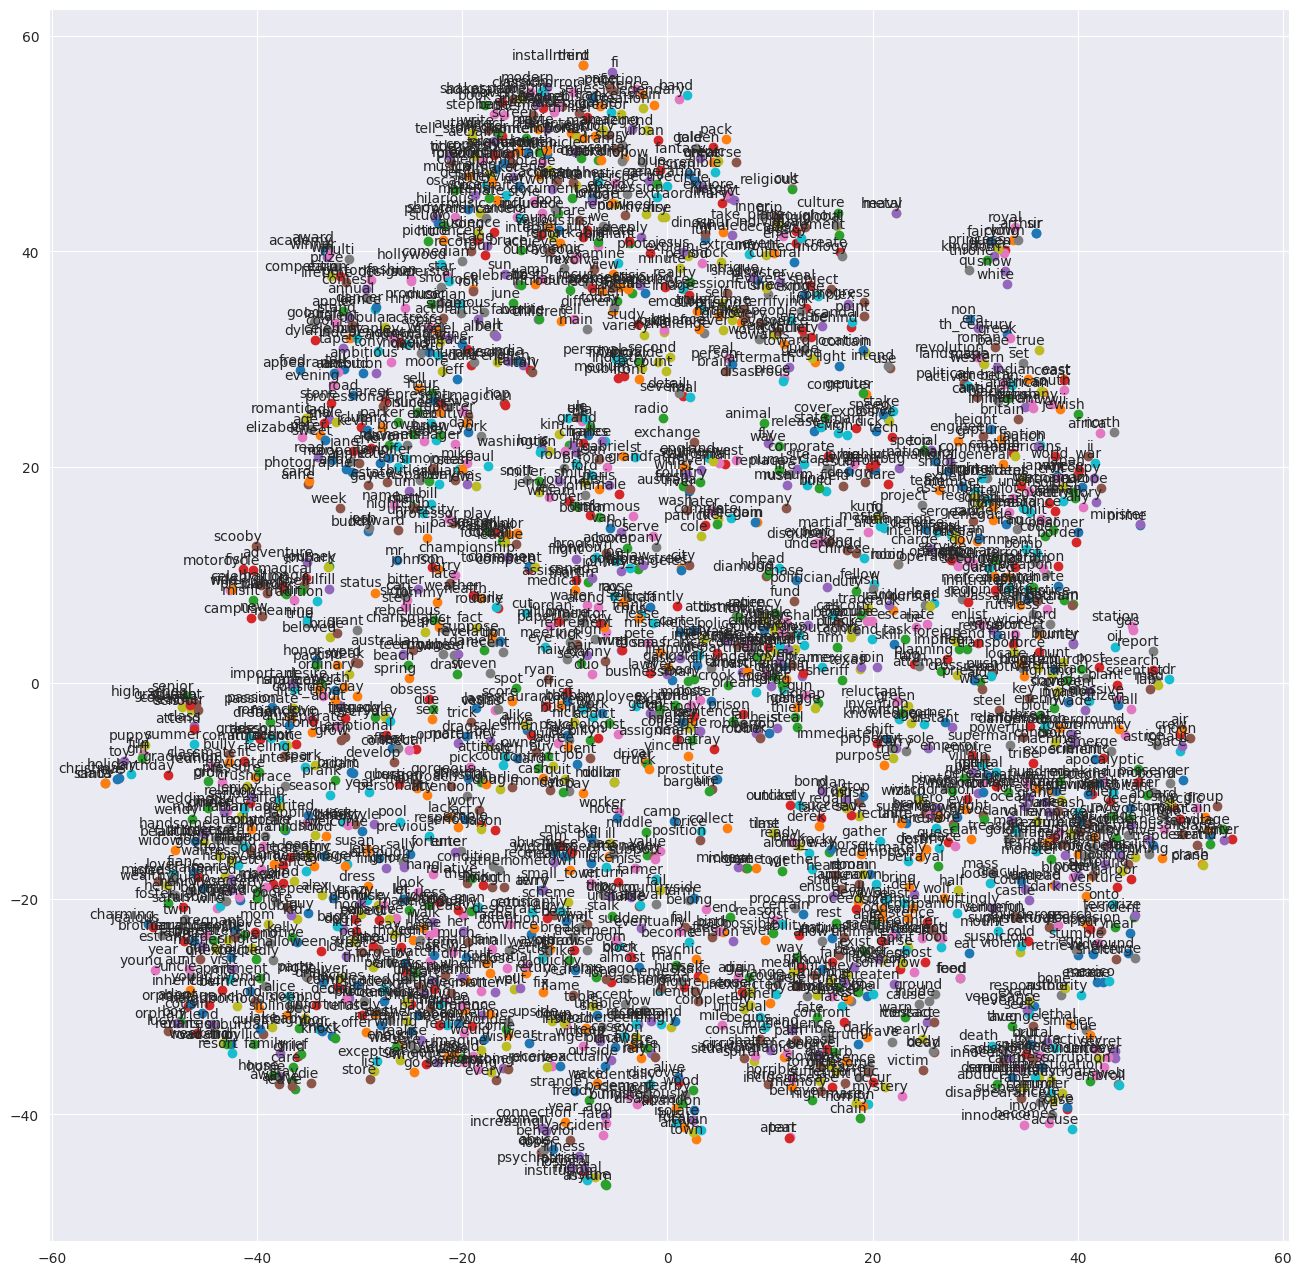

In [191]:
tsne_plot(w2v_model)

### show word vector

In [169]:
w2v_model.wv.vectors.shape

(2072, 100)

In [185]:
w2v_model.wv.vectors

array([[-0.11559001,  0.00847346,  0.04124224, ..., -0.09387907,
        -0.05167754, -0.03318235],
       [-0.2288292 ,  0.20770203,  0.08871368, ..., -0.17465298,
         0.04858419,  0.00454968],
       [-0.29028866,  0.20018661, -0.07206393, ..., -0.13007264,
         0.07950381,  0.04775157],
       ...,
       [-0.18370378,  0.14713986,  0.01818671, ..., -0.20704962,
         0.02362089,  0.00860377],
       [-0.1733336 ,  0.13956495, -0.04926237, ..., -0.27885285,
         0.0560783 ,  0.11571942],
       [-0.10060259, -0.00621862, -0.00911916, ..., -0.13809255,
         0.01306704, -0.0568722 ]], dtype=float32)

In [192]:
# w2v_model.wv.key_to_index